In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5930741144467075460,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2476859392
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11313025215844155126
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [2]:
import numpy as np
import tensorflow as tf
import random as rn

seed = 42
np.random.seed(seed)
rn.seed(seed)
tf.random.set_seed(seed)

In [3]:
import os
import numpy as np 
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.graph_objs as go

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, cross_validate, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import *

import xgboost as xgb 
import lightgbm as lgb
import bayes_opt
import itertools

from bayes_opt import BayesianOptimization

# Deep learning packages
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Dropout, LSTM
import matplotlib.pyplot as plt

# import pycaret

# 폰트 설정 - 윈도우
plt.rcParams['font.family'] = 'NanumGothic'

# 그래프의 크기
plt.rcParams['figure.figsize'] = 12, 6

# 글자 크기
plt.rcParams['font.size'] = 14

# 폰트 설정 시 - 기호 깨는거 방지하기
plt.rcParams['axes.unicode_minus'] = False

# 불필요한 경고 메시지를 나오지 않도록 한다.
import warnings
warnings.filterwarnings('ignore')

In [4]:
def nmae(true_df, pred_df):
#     target_idx = true_df.iloc[:,0]
#     pred_df = pred_df[pred_df.iloc[:,0].isin(target_idx)]
#     pred_df = pred_df.sort_values(by=[pred_df.columns[0]], ascending=[True])
#     true_df = true_df.sort_values(by=[true_df.columns[0]], ascending=[True])
    
#     true = true_df.iloc[:,1].to_numpy()
#     pred = pred_df.iloc[:,1].to_numpy()
    true = true_df.iloc[:].to_numpy()
    pred = pred_df.iloc[:].to_numpy()
    
    
    score = np.mean((np.abs(true-pred))/true)
    
    return score

def nmae_values(true, pred):
    score = np.mean((np.abs(true-pred))/true)
    
    return score

In [5]:
total = pd.read_csv('./data/한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')

In [6]:
total['구분'].unique()

array(['A', 'B', 'C', 'D', 'E', 'G', 'H'], dtype=object)

In [7]:
d_map = {}
for i, d in enumerate(total['구분'].unique()):
    d_map[d] = i
total['구분'] = total['구분'].map(d_map)

In [8]:
total['연월일'] = pd.to_datetime(total['연월일'])

In [9]:
total['year'] = total['연월일'].dt.year
total['month'] = total['연월일'].dt.month
total['day'] = total['연월일'].dt.day
total['weekday'] = total['연월일'].dt.weekday

구분 0 시행중


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


구분 0의 공급량 outlier 처리 전 plot


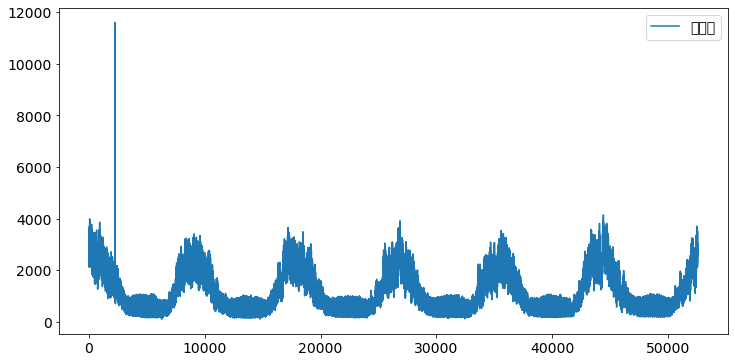

구분 0의 공급량 outlier 처리 후 plot


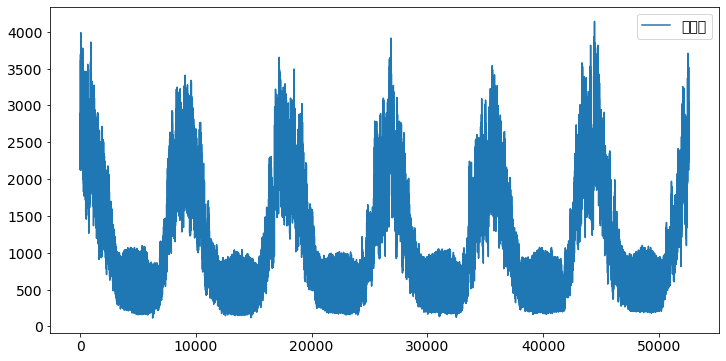

구분 1 시행중
구분 1의 공급량 outlier 처리 전 plot


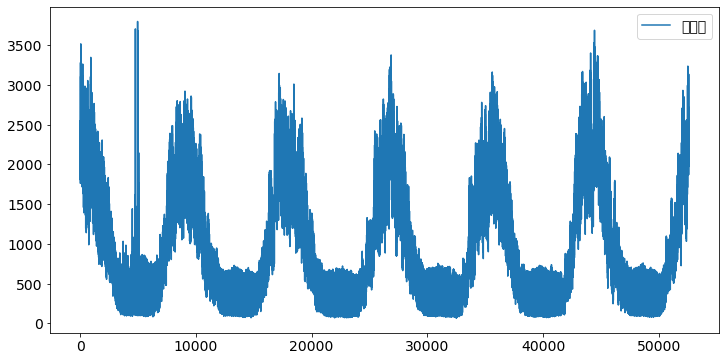

구분 1의 공급량 outlier 처리 후 plot


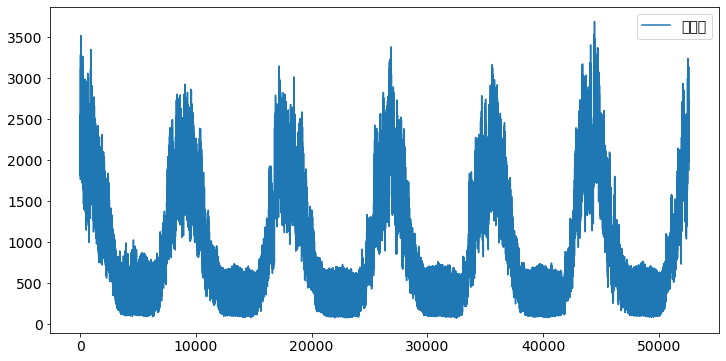

구분 2 시행중
구분 2의 공급량 outlier 처리 전 plot


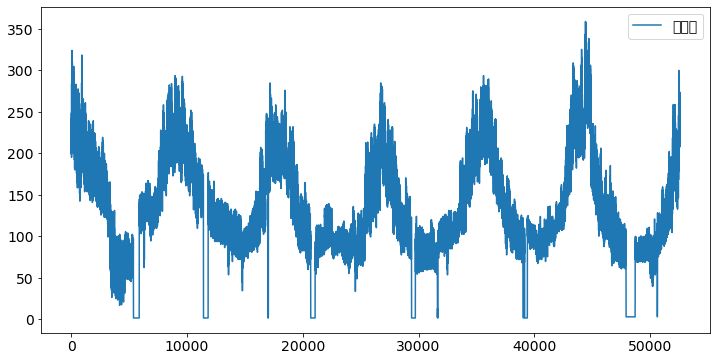

구분 2의 공급량 outlier 처리 후 plot


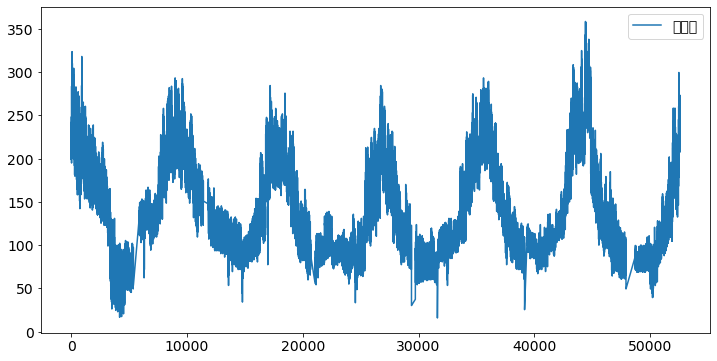

구분 3 시행중
구분 3의 공급량 outlier 처리 전 plot


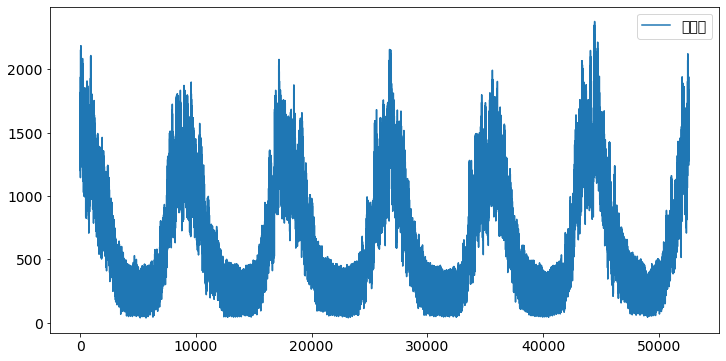

구분 3의 공급량 outlier 처리 후 plot


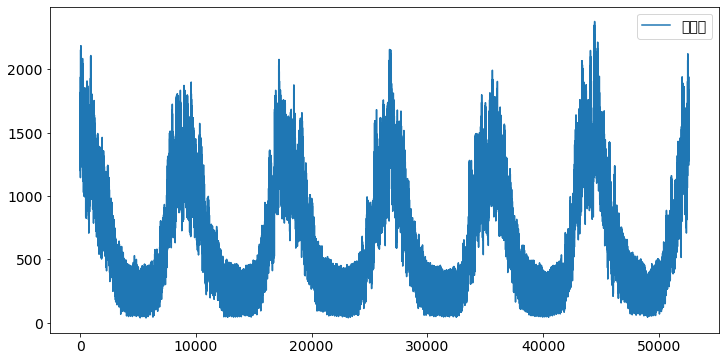

구분 4 시행중
구분 4의 공급량 outlier 처리 전 plot


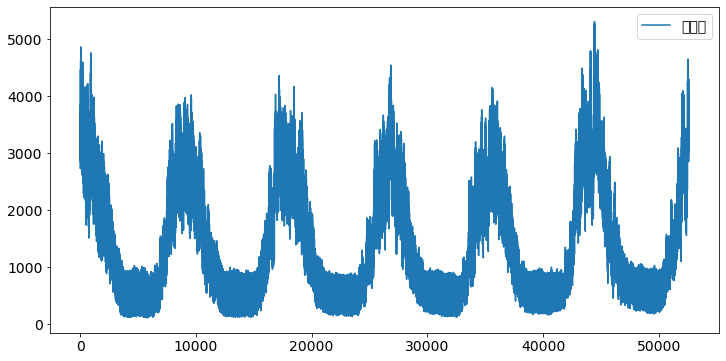

구분 4의 공급량 outlier 처리 후 plot


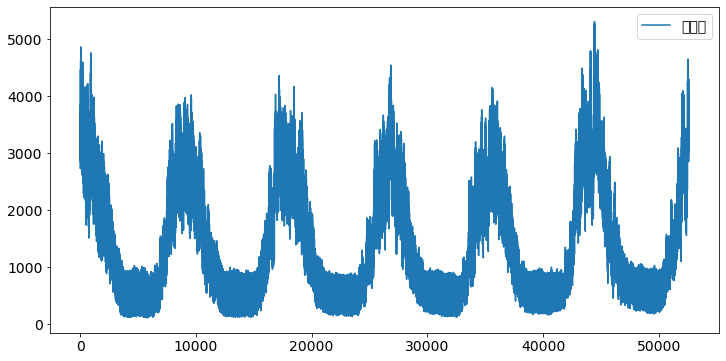

구분 5 시행중
구분 5의 공급량 outlier 처리 전 plot


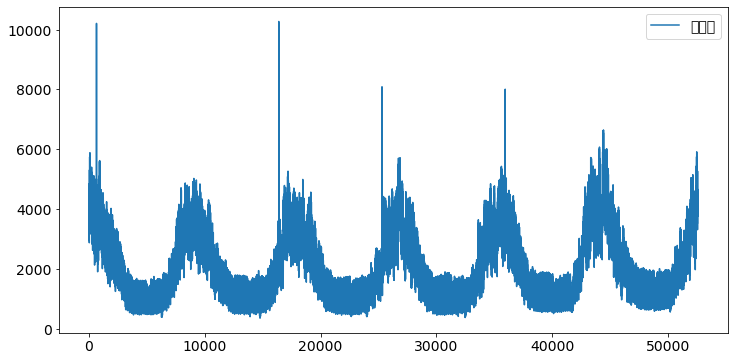

구분 5의 공급량 outlier 처리 후 plot


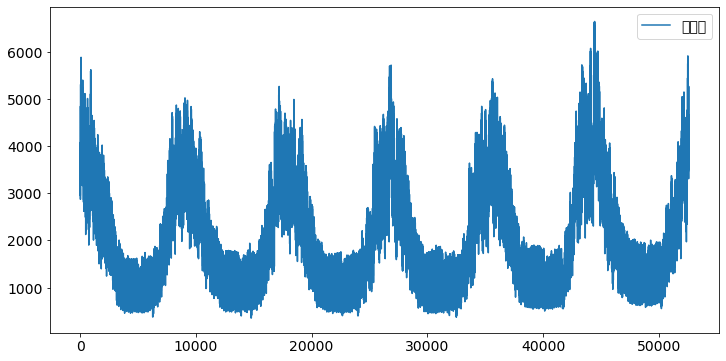

구분 6 시행중
구분 6의 공급량 outlier 처리 전 plot


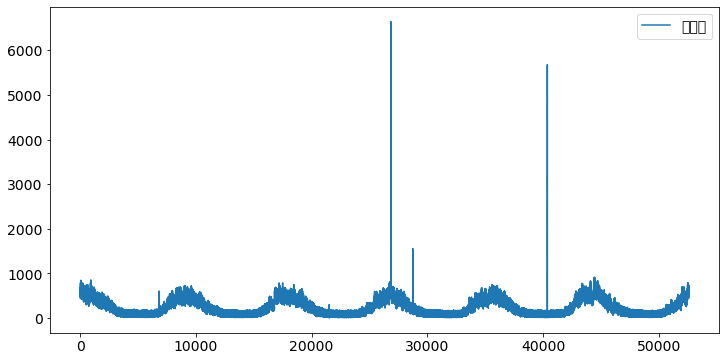

구분 6의 공급량 outlier 처리 후 plot


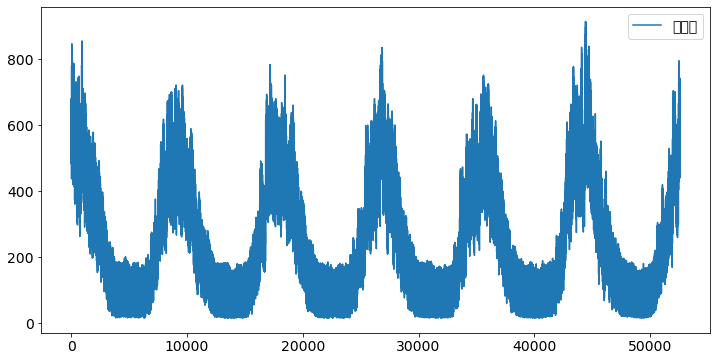

In [10]:
# 구분별로 함수를 사용해서 대체를 해보는 방법 ㄱㄱ
def outlier_prophet_ver3(data) :
  uniq = data['구분'].unique()
  result = pd.DataFrame()
  for i in uniq :
    print('구분 {} 시행중'.format(i))
    total_ = data[data['구분'] == i].reset_index()
    total_[['시간']] = total_[['시간']].astype('int') - 1
    total_[['시간']] = total_[['시간']].astype('str')
    total_['시간'] = total_['시간'].str.zfill(width=2)
    total_['일시'] = total_['연월일'].astype('str') + '-' + total_['시간'].astype('str')
    total_['일시']= pd.to_datetime(total_['일시'])
    # display(total_.head())
    df = data[data['구분'] == i].reset_index()
    print('구분 {}의 공급량 outlier 처리 전 plot'.format(i))
    df[['공급량']].plot()
    plt.show()
    df['aft_1hour'] = df['공급량'].shift(-1)
    df['bef_1hour'] = df['공급량'].shift(1)
    df['bef_diff'] = abs((df['bef_1hour'] - df['공급량'])/df['공급량'])
    df['aft_diff'] = abs((df['aft_1hour'] - df['공급량'])/df['공급량'])
    df['aft_remove'] = df['aft_diff'].shift(1)
    df['bef_remove'] = df['bef_diff'].shift(-1)
    idx = df[((df['bef_remove'] > 1) | (df['aft_remove'] > 1)) & (df['공급량'] > 100) | (df['공급량'] < 15)].index.tolist() #(round(df['공급량'], 3).isin([1.378, 2.756])
    df.at[idx, '공급량'] = np.nan

    df.공급량 = df.공급량.interpolate()
    print('구분 {}의 공급량 outlier 처리 후 plot'.format(i))
    df[['공급량']].plot()
    plt.show()
    
    total_ = pd.concat([total_.drop(['공급량'], axis = 1), df.공급량], axis = 1)
    total_ = total_.set_index(['index'])
    total_ = total_[['연월일', '시간', '구분', '공급량', 'year', 'month', 'day', 'weekday', '일시']]
#       total_.columns = ['연월일', '시간', '구분', '공급량', 'year', 'month', 'day', 'weekday', '일시']

    result = pd.concat([result, total_])
    
#     else : 
#       total_ = total_.set_index(['index'])
#       result = pd.concat([result, total_])

  return result.sort_index()    

total_ = outlier_prophet_ver3(total)

In [5]:
seoul13 = pd.read_csv('./data/weather/서울_2013.csv', encoding = 'euc-kr')
seoul14 = pd.read_csv('./data/weather/서울_2014.csv', encoding = 'euc-kr')
seoul15 = pd.read_csv('./data/weather/서울_2015.csv', encoding = 'euc-kr')
seoul16 = pd.read_csv('./data/weather/서울_2016.csv', encoding = 'euc-kr')
seoul17 = pd.read_csv('./data/weather/서울_2017.csv', encoding = 'euc-kr')
seoul18 = pd.read_csv('./data/weather/서울_2018.csv', encoding = 'euc-kr')

seoul_weather = pd.concat([seoul13, seoul14, seoul15, seoul16, seoul17, seoul18], axis = 0, ignore_index=True)
seoul_weather['일시'] = pd.to_datetime(seoul_weather['일시'])
seoul_weather.set_index('일시', inplace=True)
seoul_weather = seoul_weather[['기온(°C)', '풍속(m/s)', '습도(%)', '지면온도(°C)']]
seoul_weather.columns = ['기온', '풍속', '습도', '지면온도']
seoul_weather = seoul_weather.resample('1H').first().reset_index()

seoul_weather

,일시,기온,풍속,습도,지면온도
0,2013-01-01 00:00:00,-8.3,3.6,56.0,-3.3
1,2013-01-01 01:00:00,-8.5,4.0,57.0,-3.4
2,2013-01-01 02:00:00,-8.4,4.0,60.0,-3.4
3,2013-01-01 03:00:00,-8.1,3.4,58.0,-3.4
4,2013-01-01 04:00:00,-8.2,3.8,58.0,-3.4
...,...,...,...,...,...
52579,2018-12-31 19:00:00,-3.1,2.1,43.0,-2.2
52580,2018-12-31 20:00:00,-3.7,0.8,39.0,-3.0
52581,2018-12-31 21:00:00,-4.6,1.1,44.0,-4.1
52582,2018-12-31 22:00:00,-5.4,1.3,46.0,-5.0


In [6]:
seoul = pd.read_csv('./data/weather/seoul_test.csv', encoding = 'euc-kr')
seoul = seoul[['기온(°C)', '풍속(m/s)', '습도(%)', '지면온도(°C)']]
seoul.columns = ['기온', '풍속', '습도', '지면온도']
def weather_interpolate(weather_data) :
  df = weather_data.copy()
  col_idx = weather_data[['기온', '풍속', '습도', '지면온도']].isna().sum().index
  for col in col_idx :
    print('{}의 결측값 대체중'.format(col))
    df[[col]] = df[[col]].interpolate()
  print('완료')
  return df

weather_ = weather_interpolate(seoul)
weather_train = weather_[ : -2160]
weather_test = weather_[-2160 : ].reset_index(drop = True)

기온의 결측값 대체중
풍속의 결측값 대체중
습도의 결측값 대체중
지면온도의 결측값 대체중
완료


In [18]:
def cv_weather_lstm(data, sequence = 96, dropout = 0.4, epoch = 10, batch_size = 512, n = 2, end = 2160) :
    raw_data = data.copy()
    result = pd.DataFrame()
    verbose = 1
    
    for col in ['기온'] :
        print('기상데이터 중 {} 예측'.format(col))
        df = raw_data
        hour_data = df[[col]]
        # 파라미터 설정
        size=len(hour_data)

        #스케일링
#         scaler = MinMaxScaler()
        scaler = StandardScaler()
        scaler_fit = scaler.fit(hour_data)
        scaled_day_data=scaler_fit.transform(hour_data)
#         scaled_day_data=hour_data
        
        # lstm, 1스텝 교차검사(one-step ahead cross-validation)
        X_train,Y_train=[],[]

        # Y_train에 n개씩 들어가도록
        n_len = int((size-sequence) / n)
        for i in range(n_len) :
            j = int(i * n)
            X_train.append(np.array(scaled_day_data[j :j +sequence]))
            Y_train.append(np.array(scaled_day_data[j+sequence : j+sequence + n]))

        X_train=np.array(X_train)
        Y_train=np.array(Y_train)
        
        #예측 해야할 개수만큼 반복
        for num in range(int(end / n)):
            print('기상데이터 중 {}의 {}번째 예측중 {} / {}'.format(col, num, num, int(end / n)))
            # LSTM
            model = Sequential()
            model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh', return_sequences=True))
            model.add(Dropout(dropout)) 
            model.add(LSTM(512, activation="tanh", return_sequences=True))
            model.add(Dropout(dropout)) 
            model.add(Dense(n*2))
            model.add(LSTM(64, activation="tanh", return_sequences=False))
            model.add(Dropout(dropout))             
            model.add(Dense(n))
            model.compile(optimizer='adam', loss='mean_squared_error')

            model_fit = model.fit(X_train, Y_train, 
                                  batch_size=batch_size, epochs=epoch,
                                  verbose=verbose)

            #n+1일 값 찾기
            last_X = np.concatenate((X_train[-1][n:],Y_train[-1]),axis=0)
            last_Y = model.predict(np.array([last_X]))

            #n+1일 값 추가
            new_X_train=np.concatenate((X_train[:],np.array([last_X])),axis=0)
            new_Y_train=np.concatenate((Y_train[:],np.array([last_Y.T])),axis=0)

            X_train=np.array(new_X_train)
            Y_train=np.array(new_Y_train)

        model.summary()
        
        Y_plot = pd.DataFrame(scaler.inverse_transform(Y_train.reshape(-1, 1)))  # minmaxscaling
#         Y_plot = pd.DataFrame(scaler.inverse_transform(Y_train).reshape(-1, 1))  # standardscaling
#         Y_plot = pd.DataFrame(Y_train.reshape(-1, 1)) # no scaling
        Y_plot = Y_plot.rename({0:col},axis="columns")
        Y_pred = Y_plot.iloc[-end : ].reset_index(drop = True)
#         print('기상데이터 중 {}의 nmae :'.format(col), nmae(raw_data_valid.iloc[:end][[col]], Y_pred.reset_index(drop = True)))
        
        result = pd.concat([result, Y_pred])
        
    return result.reset_index(drop = True)

result = cv_weather_lstm(weather_train, sequence = 2400, dropout = 0.05, epoch = 50, batch_size = 512, n = 40, end = 2160)

기상데이터 중 기온 예측
기상데이터 중 기온의 0번째 예측중 0 / 54
Epoch 1/50


ResourceExhaustedError:    OOM when allocating tensor with shape[2400,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node CudnnRNN}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[sequential_540/lstm_1621/PartitionedCall]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_5924132]

Function call stack:
train_function -> train_function -> train_function


<AxesSubplot:>

0.9622377095012721


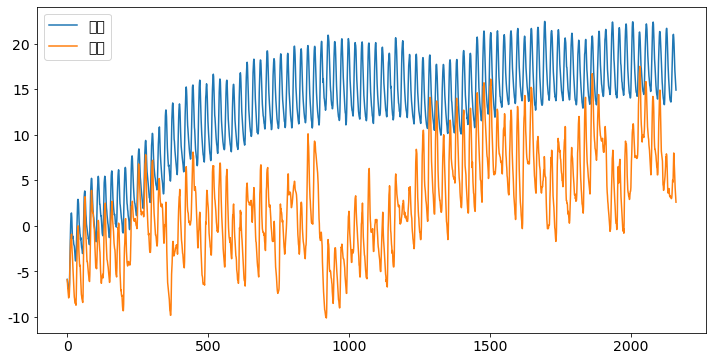

In [16]:
display(pd.concat([result, weather_test.iloc[ : 2160][['기온']]], axis = 1).plot() )
print(nmae(result, weather_test.iloc[ : 2160][['기온']]))

In [17]:
display(weather_train.iloc[-5 :][['기온']])
display(weather_test.iloc[ : 50][['기온']])

,기온
52579,-3.7
52580,-4.6
52581,-5.4
52582,-5.2
52583,-5.5


,기온
0,-5.9
1,-6.5
2,-6.9
3,-7.2
4,-7.6
5,-7.9
6,-7.7
7,-7.7
8,-7.0
9,-4.9


dropout = 0.1 
기상데이터 중 기온의 nmae : -0.040189759395111185
dropout = 0.05
기상데이터 중 기온의 nmae : -0.06410314159451305

- sequence : 96
    - 80일때 
        - 구분0의 nmae : 0.3410885353526143, dropout = 0.3

    - 16일때
        - 구분0의 nmae : 0.32697169562467715, dropout = 0.3
        - 구분0의 nmae : 0.29497400464949414, dropout = 0.4

    - 4일때
        - 구분0의 nmae : 0.23139905465500307, dropout = 0.4 -- nmae : 0.2906449310902519
        - 신경망 구조 변경 해봄
        - 구분0의 nmae : 0.2945048087111536

- sequence : 1580
    - 80
        - 구분0의 nmae : 0.3097602606776238
    - 8
        - 구분0의 nmae : 0.29716304565698237


In [22]:
import torch.nn as nn

rnn_type='LSTM'
lstm = getattr(nn, rnn_type)(60, 20, 1, batch_first=False, dropout=0.2, bidirectional=1)
class SingleRNN(nn.Module):
    """
    Container module for a single RNN layer.
    
    args:
        rnn_type: string, select from 'RNN', 'LSTM' and 'GRU'.
        input_size: int, dimension of the input feature. The input should have shape 
                    (batch, seq_len, input_size).
        hidden_size: int, dimension of the hidden state. 
        dropout: float, dropout ratio. Default is 0.
        bidirectional: bool, whether the RNN layers are bidirectional. Default is False.
    """

    def __init__(self, rnn_type, input_size, hidden_size, dropout=0, bidirectional=False):
        super(SingleRNN, self).__init__()
        
        self.rnn_type = rnn_type
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_direction = int(bidirectional) + 1
        
        self.rnn = getattr(nn, rnn_type)(input_size, hidden_size, 1, dropout=dropout, batch_first=False, bidirectional=bidirectional)


    def forward(self, input):
        # input shape: batch, seq, dim
        output = input
        rnn_output, _ = self.rnn(output)
        return rnn_output

In [26]:
SingleRNN(rnn_type, 60, 20)

SingleRNN(
  (rnn): LSTM(60, 20)
)

In [28]:
import numpy as np 
import pandas as pd 
import pandas_datareader.data as pdr 
import matplotlib.pyplot as plt 
import datetime 
import torch 
import torch.nn as nn 
from torch.autograd import Variable 
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader